**Ranjan Sapkota**

**Prediction with Machine Learning for Economist**

**Professor Gabor Bekes**

**Assignment 1**


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statsmodels.iolib.summary2 import summary_col
from tabulate import tabulate
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt


In [2]:
#df = pd.read_csv('/content/morg-2014-emp.csv')
df = pd.read_csv('morg-2014-emp.csv')

# Data Cleaning

Here, I choose the occupation only Economists (Occupation Code: 1800).

It calculates hourly earnings by dividing weekly earnings by usual hours worked, ensuring there are no missing or infinite values.

The log transformation of earnings (`lnearnings`) is computed to normalize the distribution, and an age squared (`agesqr`) variable is created to capture potential nonlinear effects of age on earnings.

Finally, categorical variables such as gender, race, and employment type are converted into categorical data types to ensure proper encoding for regression analysis.



In [3]:

# Filter dataset for Economists (Occupation Code: 1800)
econ_df = df[df["occ2012"] == 1800].copy()

# Compute hourly earnings
econ_df["earnings_per_hour"] = econ_df["earnwke"] / econ_df["uhours"]

# Drop rows with missing or infinite values in earnings_per_hour
econ_df = econ_df.dropna(subset=["earnings_per_hour"])
econ_df = econ_df[econ_df["earnings_per_hour"].replace([float("inf"), float("-inf")], pd.NA).notna()]


# Rename 'class' column to avoid syntax issues
econ_df = econ_df.rename(columns={"class": "employment_class"})

#calculate agesqr for later purposes
econ_df['agesqr'] = econ_df['age']**2
econ_df['lnearnings'] = np.log(econ_df['earnings_per_hour'])

# Convert categorical variables to categorical type to ensure correct encoding
categorical_cols = ["sex", "race", "unionmme", "employment_class", "marital", "ownchild"]
for col in categorical_cols:
    econ_df[col] = econ_df[col].astype("category")

#econ_df

# Regression Model

**Basic Interpretation**

The four OLS models predict the log of earnings per hour using different levels of complexity.

Model 1: It includes education (grade92) and age (age), as these are well-known predictors of earnings in human capital theory.

Model 2: It adds a squared age term (agesqr) to capture nonlinear effects of age (e.g., wages grow at different rates throughout life) and sex to account for gender wage differences.

Model 3: It incorporates race and employment class, as racial disparities and job types can impact earnings.

Model 4: It is the the most complex model, introducing union membership (unionmme) and number of children (ownchild) to assess whether unionization and family responsibilities affect wages.

This stepwise approach allows us to compare model fit and determine the trade-off between complexity and predictive power.

In [4]:
# regression models
models = {
    "Model 1": "lnearnings ~ grade92 + age",
    "Model 2": "lnearnings ~ grade92 + age + agesqr+ sex ",
    "Model 3": "lnearnings ~ grade92 + age + agesqr+ sex + race + employment_class",
    "Model 4": "lnearnings ~ grade92 + age + agesqr+ sex + race + employment_class + unionmme+ ownchild"
}

# Fit models
models_fitted = [smf.ols(formula=formula, data=econ_df).fit() for formula in models.values()]

# regression table
table = summary_col(models_fitted, stars=True, float_format="%0.3f",
                    model_names=list(models.keys()),
                    info_dict={'Observations': lambda x: f"{int(x.nobs)}",
                               'R2': lambda x: f"{x.rsquared:.3f}",
                               'Adjusted R2': lambda x: f"{x.rsquared_adj:.3f}",
                               'BIC': lambda x: f"{x.bic:.0f}"})

print(table)


                                        Model 1  Model 2   Model 3   Model 4 
-----------------------------------------------------------------------------
Intercept                               -3.061*  -3.632** -1.904    -1.383   
                                        (1.742)  (1.819)  (1.993)   (2.186)  
grade92                                 0.139*** 0.118*** 0.095*    0.083    
                                        (0.040)  (0.041)  (0.047)   (0.051)  
age                                     0.014**  0.093**  0.058     0.057    
                                        (0.006)  (0.046)  (0.043)   (0.047)  
sex[T.2]                                         -0.087   -0.066    -0.083   
                                                 (0.091)  (0.086)   (0.090)  
agesqr                                           -0.001*  -0.001    -0.000   
                                                 (0.001)  (0.001)   (0.001)  
race[T.2]                                                 -0.31

# BIC/RMSE

Here, we calculate and present the key performance metrics for each regression model.

It iterates through the models, computing Root Mean Squared Error (RMSE), Bayesian Information Criterion (BIC), R-squared, and Adjusted R-squared to evaluate model fit and complexity.

In [5]:
# Compute RMSE and BIC for each model in the full sample
full_sample_metrics = {
    "Model": [],
    "N coeff": [],
    "R-squared": [],
    "Adjusted R-squared": [],
    "RMSE (Full Sample)": [],
    "Residual Std. Error": [],
    "BIC (Full Sample)": []
}

for model_name, fitted_model in zip(models.keys(), models_fitted):
    # RMSE: Root Mean Squared Error
    predictions = fitted_model.predict(econ_df)
    rmse = np.sqrt(mean_squared_error(econ_df["lnearnings"], predictions))

    # Store results
    full_sample_metrics["Model"].append(model_name)
    full_sample_metrics["N coeff"].append(len(fitted_model.params))
    full_sample_metrics["R-squared"].append(fitted_model.rsquared)
    full_sample_metrics["Adjusted R-squared"].append(fitted_model.rsquared_adj)
    full_sample_metrics["RMSE (Full Sample)"].append(rmse)
    full_sample_metrics["Residual Std. Error"].append(np.sqrt(fitted_model.mse_resid))
    full_sample_metrics["BIC (Full Sample)"].append(fitted_model.bic)

# Convert to DataFrame
full_sample_metrics_df = pd.DataFrame(full_sample_metrics)

# Format numeric values for readability
full_sample_metrics_df["RMSE (Full Sample)"] = full_sample_metrics_df["RMSE (Full Sample)"].apply(lambda x: f"{x:,.3f}")
full_sample_metrics_df["BIC (Full Sample)"] = full_sample_metrics_df["BIC (Full Sample)"].apply(lambda x: f"{x:,.0f}")
full_sample_metrics_df["Residual Std. Error"] = full_sample_metrics_df["Residual Std. Error"].apply(lambda x: f"{x:,.3f}")
full_sample_metrics_df["Adjusted R-squared"] = full_sample_metrics_df["Adjusted R-squared"].apply(lambda x: f"{x:.3f}")

# table
table_str = tabulate(full_sample_metrics_df, headers="keys", tablefmt="fancy_grid", showindex=False)
print(table_str)


╒═════════╤═══════════╤═════════════╤══════════════════════╤══════════════════════╤═══════════════════════╤═════════════════════╕
│ Model   │   N coeff │   R-squared │   Adjusted R-squared │   RMSE (Full Sample) │   Residual Std. Error │   BIC (Full Sample) │
╞═════════╪═══════════╪═════════════╪══════════════════════╪══════════════════════╪═══════════════════════╪═════════════════════╡
│ Model 1 │         3 │    0.25742  │                0.236 │                0.376 │                 0.384 │                  75 │
├─────────┼───────────┼─────────────┼──────────────────────┼──────────────────────┼───────────────────────┼─────────────────────┤
│ Model 2 │         5 │    0.299995 │                0.258 │                0.365 │                 0.379 │                  80 │
├─────────┼───────────┼─────────────┼──────────────────────┼──────────────────────┼───────────────────────┼─────────────────────┤
│ Model 3 │        12 │    0.545879 │                0.461 │                0.294 │       

**Basic Interpretation**

This table presents the performance metrics of four regression models with increasing complexity. Model complexity is measured by the number of coefficients (`N coeff`), which increases from 3 (Model 1) to 16 (Model 4).

As complexity grows, R-squared improves from 0.257 to 0.556, indicating better model fit. However, Adjusted R-squared peaks at Model 3 (0.461) and slightly drops in Model 4 (0.435), suggesting diminishing returns in predictive power.

RMSE (Full Sample) decreases, meaning better predictions, but BIC initially decreases (Model 3: 79) before rising sharply in Model 4 (94), signaling possible overfitting.

This trade-off highlights that Model 3 balances predictive accuracy and complexity best, while Model 4 may be unnecessarily complex.

# Cross Validated RMSE

Here, we perform the K-Fold Cross-Validation (CV) to evaluate the predictive performance of the regression models.

We use the 5-fold CV, the dataset is split into five subsets, where each model is trained on four folds and tested on the remaining fold, repeating this process for all combinations.

The RMSE is computed for each fold, measuring prediction accuracy. Results are stored in a DataFrame, with an average RMSE row summarizing overall performance across folds.

The final table is formatted for clarity, helping assess which model generalizes best to unseen data.

In [6]:
#Set up K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store cross-validated RMSE results
cv_results = {model: [] for model in models.keys()}

# Iterate over K-Fold splits
for fold, (train_index, test_index) in enumerate(kf.split(econ_df), start=1):
    train_data, test_data = econ_df.iloc[train_index], econ_df.iloc[test_index]

    for model_name, formula in models.items():
        cv_model = smf.ols(formula=formula, data=train_data).fit()
        predictions = cv_model.predict(test_data)
        rmse = np.sqrt(mean_squared_error(test_data["lnearnings"], predictions))
        cv_results[model_name].append(rmse)

# Convert results to DataFrame (Numeric Values Only)
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.insert(0, "Fold No.", [f"Fold {i+1}" for i in range(kf.get_n_splits())])

# Add average row (keeping numeric format)
average_rmse = cv_results_df.iloc[:, 1:].mean()
cv_results_df.loc[len(cv_results_df)] = ["Average"] + average_rmse.tolist()

# Format only when printing (No dtype issues)
formatted_table = cv_results_df.copy()
for col in formatted_table.columns[1:]:  # Format only RMSE values
    formatted_table[col] = formatted_table[col].apply(lambda x: f"{x:,.3f}")

print("\nTable: CV RMSE\n")

# Print table in a nicely formatted style
table_str = tabulate(formatted_table, headers="keys", tablefmt="fancy_grid", showindex=False)
print(table_str)


Table: CV RMSE

╒════════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│ Fold No.   │   Model 1 │   Model 2 │   Model 3 │   Model 4 │
╞════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Fold 1     │     0.461 │     0.487 │     0.547 │     0.565 │
├────────────┼───────────┼───────────┼───────────┼───────────┤
│ Fold 2     │     0.429 │     0.424 │     0.482 │     0.493 │
├────────────┼───────────┼───────────┼───────────┼───────────┤
│ Fold 3     │     0.33  │     0.308 │     0.412 │     0.44  │
├────────────┼───────────┼───────────┼───────────┼───────────┤
│ Fold 4     │     0.452 │     0.45  │     0.42  │     0.414 │
├────────────┼───────────┼───────────┼───────────┼───────────┤
│ Fold 5     │     0.262 │     0.237 │     0.284 │     0.356 │
├────────────┼───────────┼───────────┼───────────┼───────────┤
│ Average    │     0.387 │     0.381 │     0.429 │     0.454 │
╘════════════╧═══════════╧═══════════╧═══════════╧═══════════╛


**Basic Interpretation**

Here, the table shows the Cross-Validated RMSE for each model across five folds, with an average RMSE row summarizing overall performance.

Given that, Lower RMSE values are meant to indicate better predictive accuracy, we see that Model 2 has the lowest average RMSE (0.381), suggesting it generalizes best to unseen data, while Model 4 has the highest RMSE (0.454), which potentially indicates overfitting in the model that I have presented here.  

Despite Model 3 showing improvement in training performance, its higher cross-validated RMSE (0.429) suggests it may not generalize as well as Model 2.

# Visualization

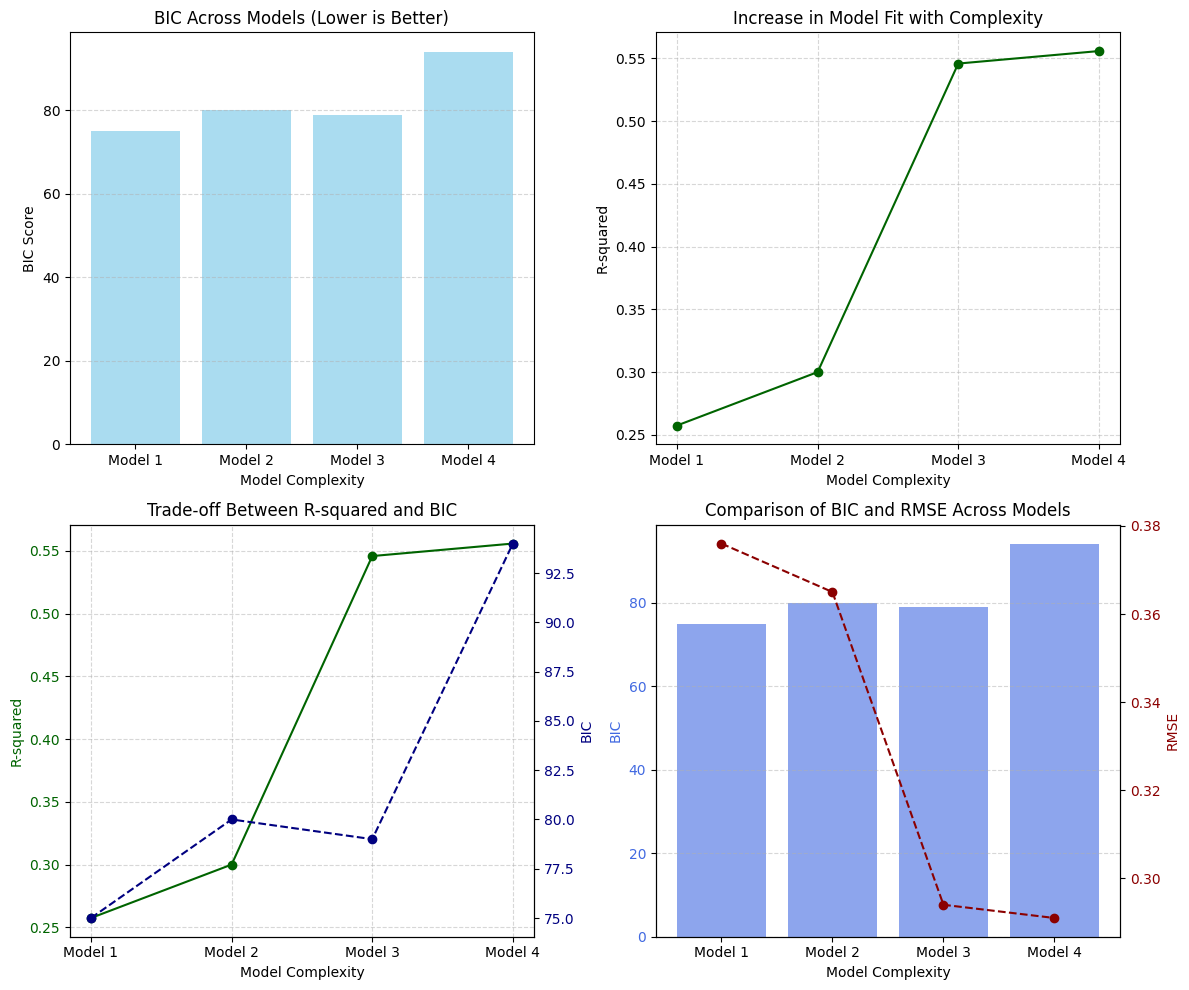

In [7]:

# Convert necessary columns to float for plotting
full_sample_metrics_df["BIC (Full Sample)"] = full_sample_metrics_df["BIC (Full Sample)"].astype(float)
full_sample_metrics_df["R-squared"] = full_sample_metrics_df["R-squared"].astype(float)
full_sample_metrics_df["RMSE (Full Sample)"] = full_sample_metrics_df["RMSE (Full Sample)"].astype(float)

# Define x-axis (Model Complexity)
models_x = ["Model 1", "Model 2", "Model 3", "Model 4"]
x = np.arange(len(models_x))

# Create subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Simple Bar Chart: BIC Across Models
axes[0, 0].bar(models_x, full_sample_metrics_df["BIC (Full Sample)"], color='skyblue', alpha=0.7)
axes[0, 0].set_xlabel("Model Complexity")
axes[0, 0].set_ylabel("BIC Score")
axes[0, 0].set_title("BIC Across Models (Lower is Better)")
axes[0, 0].grid(axis='y', linestyle="--", alpha=0.5)

# Line Plot: R² vs. Model Complexity
axes[0, 1].plot(models_x, full_sample_metrics_df["R-squared"], marker="o", linestyle="-", color="darkgreen")
axes[0, 1].set_xlabel("Model Complexity")
axes[0, 1].set_ylabel("R-squared")
axes[0, 1].set_title("Increase in Model Fit with Complexity")
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# Trade-off Between R-squared and BIC
ax1 = axes[1, 0]
ax2 = ax1.twinx()
ax1.plot(models_x, full_sample_metrics_df["R-squared"], marker="o", color="darkgreen", linestyle="-", label="R-squared")
ax2.plot(models_x, full_sample_metrics_df["BIC (Full Sample)"], marker="o", color="navy", linestyle="--", label="BIC")
ax1.set_xlabel("Model Complexity")
ax1.set_ylabel("R-squared", color="darkgreen")
ax2.set_ylabel("BIC", color="navy")
ax1.set_title("Trade-off Between R-squared and BIC")
ax1.tick_params(axis='y', labelcolor="darkgreen")
ax2.tick_params(axis='y', labelcolor="navy")
ax1.grid(True, linestyle="--", alpha=0.5)

# Bar Chart: BIC and RMSE Across ModelS
ax3 = axes[1, 1]
ax4 = ax3.twinx()
ax3.bar(x, full_sample_metrics_df["BIC (Full Sample)"], color='royalblue', alpha=0.6, label="BIC")
ax4.plot(x, full_sample_metrics_df["RMSE (Full Sample)"], marker="o", color="darkred", linestyle="--", label="RMSE")
ax3.set_xlabel("Model Complexity")
ax3.set_ylabel("BIC", color='royalblue')
ax4.set_ylabel("RMSE", color='darkred')
ax3.set_title("Comparison of BIC and RMSE Across Models")
ax3.set_xticks(x)
ax3.set_xticklabels(models_x)
ax3.grid(axis='y', linestyle="--", alpha=0.5)
ax3.tick_params(axis='y', labelcolor='royalblue')
ax4.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()
